In [263]:
from IPython import get_ipython

import numpy as np
from numpy import random, dtype
from array import array
import math
from math import floor

import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib widget
# %matplotlib widget

from os import path, mkdir
from tqdm import tqdm
import tqdm.notebook as tq

import ROOT
from ROOT import TCanvas, TFile, TPaveText, TMath, TF1, TH1, TH1F, TH2D, TH2F, TH3F, TRandom, TPolyMarker3D, TGraphErrors, TAxis, TGaxis
from ROOT import gROOT, gBenchmark, gRandom, gInterpreter, gPad, gStyle, gDirectory, TSpline3, TSpline5
from ROOT import nullptr, kBlue, kRed, kBlack

# import rootpy
# %jsroot on

In [264]:
ROOT.gROOT.LoadMacro('./includes/rootlogon.C')

0


 Beginning new ROOT session with private TStyle 


In [265]:
canvasCnt = 0
canvases = []

def NewCanvas(s1 = 800, s2 = 500):
    
    global canvasCnt, canvases
    n = "c_" + str(canvasCnt)
    canvases.append(TCanvas(n, n, s1, s2))
    canvases[canvasCnt].Draw()
    canvasCnt = canvasCnt+1
    return canvasCnt-1, canvases[canvasCnt-1]

In [266]:
def FillGraph(gra: TGraphErrors, x, y, ex, ey):
    gra.AddPoint(x, y)
    n = gra.GetN()
    gra.SetPointError(n-1, ex, ey)
    return n

In [267]:
run = "run530164"
out = F"out/{run}/reso_corr/"
exten = ".pdf"
fin = TFile(F"../data/roottople_new/{run}_new.root")
tre = fin.Get("t")

try:
    mkdir(out)
except:
    pass

mtMcp = "0.5*(tim[2]+tim[3])"
dtMcp = "tim[2]-tim[3]"
mtSipm = "0.5*(tim[1]+tim[0])"
dtSipm = "tim[1]-tim[0]"
mcSipm = "0.5*(charge[1]+charge[0])"
asymSipm = "(charge[1]-charge[0])/(charge[1]+charge[0])"
cutAnd = " && "

fidlarge = np.array([5.7, 6.7, 4.7, 5.6])
fidlarge = [5.7, 6.7, 4.7, 5.6] if run == "run530164" else fidlarge
fidlarge = [5.9, 7.0, 4.7, 5.6] if run == "run530167" else fidlarge 
fidlarge = [5.9, 7.0, 4.5, 5.5] if run == "run530181" else fidlarge
fidlarge = [5.9, 7.0, 4.5, 5.5] if run == "run530178" else fidlarge
fidLarge = F"cryPos[0]>{fidlarge[0]} && cryPos[0]<{fidlarge[1]} && cryPos[1]>{fidlarge[2]} && cryPos[1]<{fidlarge[3]}" 

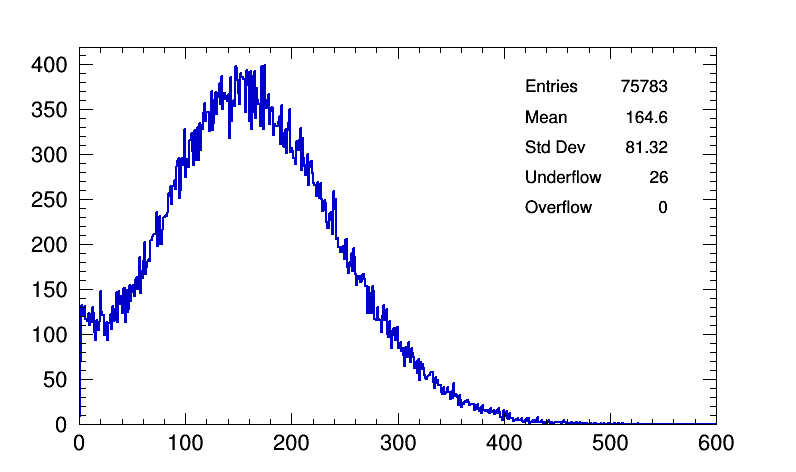

In [268]:
NewCanvas()
tre.Draw("charge[0]>>(600, 0, 600)", fidLarge)
cCutSipm = "charge[0] > 60 && charge[1] > 60"

Info in <TCanvas::Print>: pdf file out/run530164/reso_corr/beforeCorr.pdf has been created


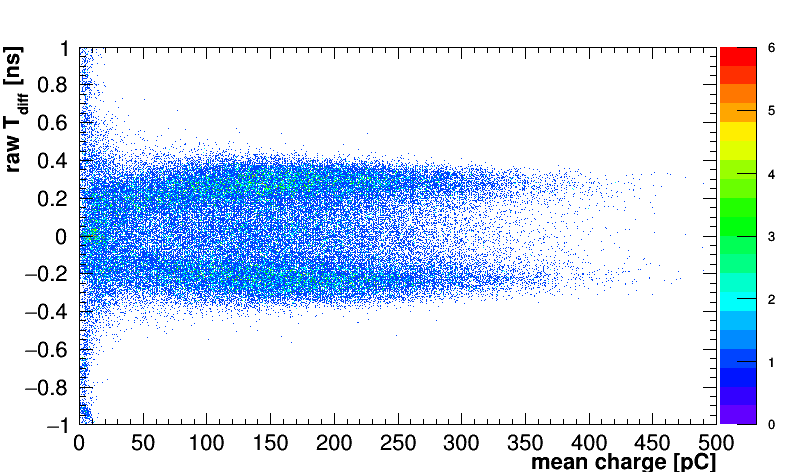

In [269]:
hh = TH2D("hh", "hh", 1000, 0, 500, 1000, -1, 1)
tre.Draw("(tim[0]-tim[1])/2 : charge[0]/2+charge[1]/2 >> hh", "", "")
hh.SetStats(0)
hh = gPad.GetPrimitive("hh")
hh.SetTitle(run)
hh.GetXaxis().SetTitle("mean charge [pC]")
hh.GetYaxis().SetTitle("raw T_{diff} [ns]")
_, cc = NewCanvas()
hh.Draw("zcol")

cc.SaveAs(out+"beforeCorr"+exten)

-0.3836545109828468   -11.112640115154313


Info in <TCanvas::Print>: pdf file out/run530164/reso_corr/corrHist.pdf has been created
Info in <TCanvas::Print>: pdf file out/run530164/reso_corr/correction.pdf has been created


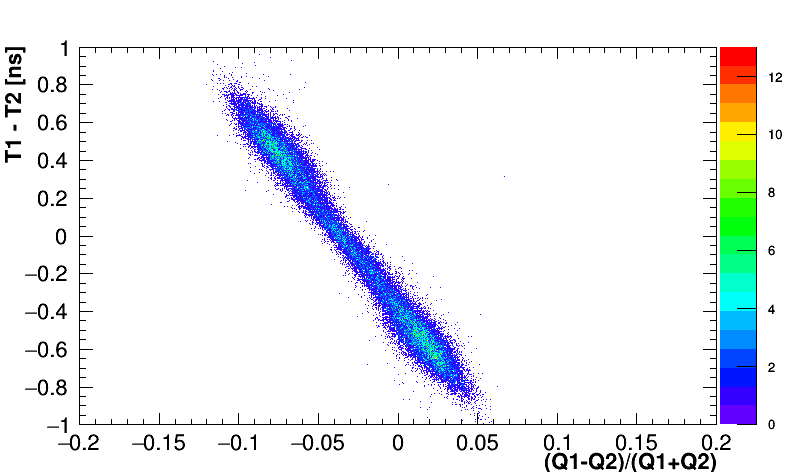

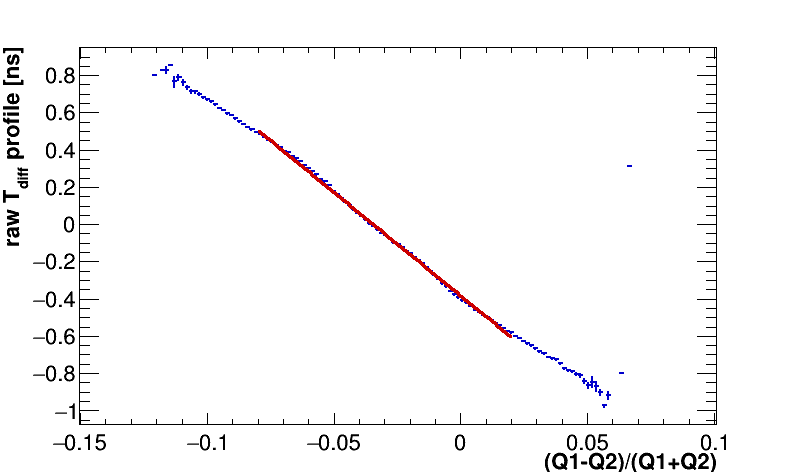

In [280]:
tre.Draw(F"tim[1]-tim[0]:{asymSipm}>>corrHist(1000, -.2, .2, 1000, -1, 1)", fidLarge + " && " + cCutSipm, "goff")
corrHist = gDirectory.Get("corrHist")
_, cc = NewCanvas()
cc.SetLogz(0)
corrHist.SetTitle(run)
corrHist.GetXaxis().SetTitle("(Q1-Q2)/(Q1+Q2)")
corrHist.GetYaxis().SetTitle("T1 - T2 [ns]")
corrHist.Draw("zcol")
corrHist.SetStats(0)
cc.SaveAs(out+"corrHist"+exten)


corrProf = corrHist.ProfileX()
corrProf.Rebin(4)
corrProf.SetStats(0)
corrProf.GetXaxis().SetRangeUser(-0.15, 0.1)
corrProf.SetMarkerSize(.2)
corrProf.SetMarkerStyle(20)
corrProf.GetXaxis().SetTitle("(Q1-Q2)/(Q1+Q2)")
corrProf.GetYaxis().SetTitle("raw T_{diff} profile [ns]")

_, ccc = NewCanvas()
corrProf.Draw()
corrProfCopy = corrProf.Clone()

lin = TF1 ("lin", "[0] + [1]*x", -0.08, 0.02)
corrProfCopy.Fit(lin, "SREMQ")

corrOffs, corrSlope = lin.GetParameter(0), lin.GetParameter(1)
print(F"{corrOffs}   {corrSlope}")

ccc.SaveAs(out+"correction"+exten)

qAsymCut = F"{asymSipm} > -0.1 && {asymSipm} < 0.05"

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_4
Info in <TCanvas::Print>: pdf file out/run530164/reso_corr/corrSpline.pdf has been created


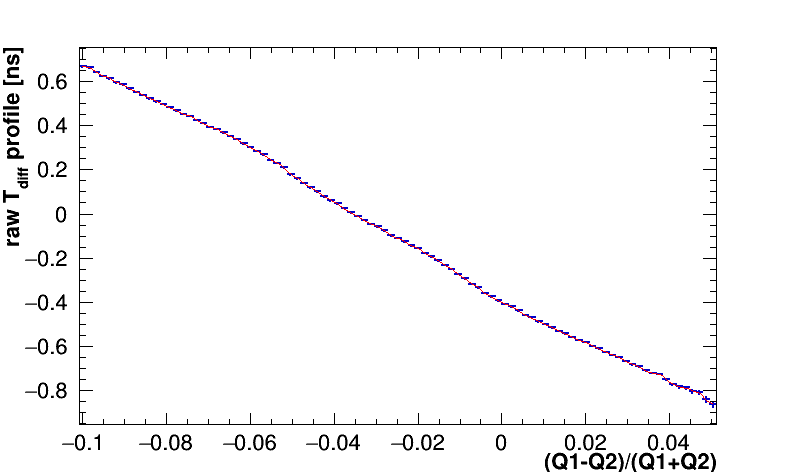

In [271]:
splineCorr = TSpline3(corrProf)
corrProf.GetXaxis().SetRangeUser(-0.10, 0.05)
_, cccc = NewCanvas()
corrProf.Draw()
splineCorr.SetLineColor(kRed)
splineCorr.Draw("same")

cccc.SaveAs(out+"corrSpline"+exten)

In [272]:
histoS = TH2D("histo", "histo", 1000, 0, 500, 1000, -1, 1)

for i in tq.tqdm(range(0, tre.GetEntries())):
    tre.GetEntry(i)
    val = tre.tim[0] - tre.tim[1] + splineCorr.Eval((tre.charge[1]-tre.charge[0])/(tre.charge[1]+tre.charge[0]))
    val *= 0.5
    mq = 0.5* (tre.charge[1]+tre.charge[0])
    histoS.Fill(mq, val)



  0%|          | 0/99039 [00:00<?, ?it/s]

Info in <TCanvas::Print>: pdf file out/run530164/reso_corr/afterCorrSpline.pdf has been created


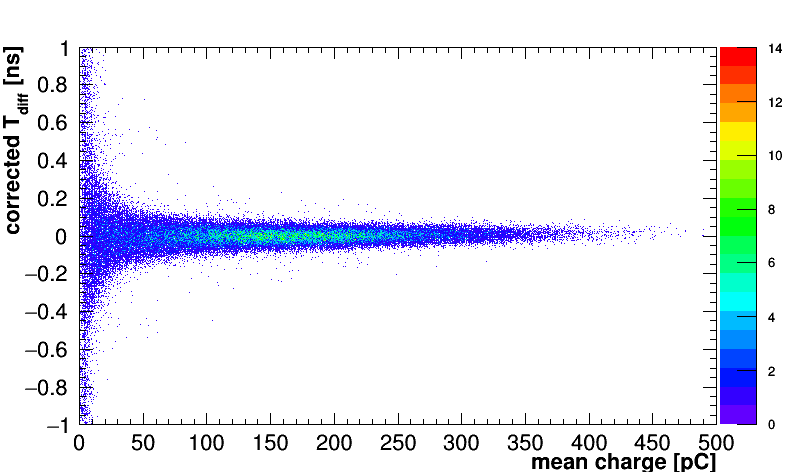

In [273]:
_, ccc = NewCanvas()
histoS.SetStats(0)
histoS.GetXaxis().SetTitle("mean charge [pC]")
histoS.GetYaxis().SetTitle("corrected T_{diff} [ns]")
histoS.Draw("zcol")
ccc.SaveAs(out+"afterCorrSpline"+exten)

-0.3836545109828468 + -11.112640115154313*((charge[1]-charge[0])/(charge[1]+charge[0]))


Warning in <TFile::Append>: Replacing existing TH1: histo (Potential memory leak).
Info in <TCanvas::Print>: pdf file out/run530164/reso_corr/afterCorrection.pdf has been created


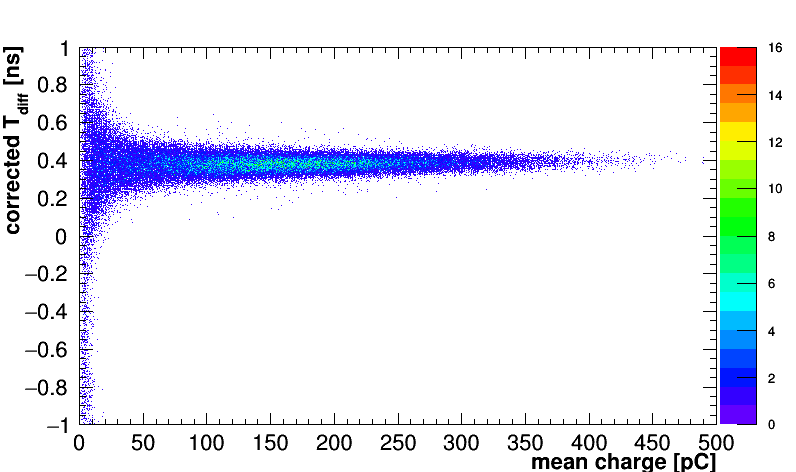

In [274]:
histo = TH2D("histo", "histo", 1000, 0, 500, 1000, -1, 1)
corrStr = F"{corrOffs} + {corrSlope}*({asymSipm})"
print(corrStr)
tre.Draw(F"(tim[0]-tim[1] - {corrStr})/2 : charge[0]/2+charge[1]/2 >> histo", qAsymCut, "")
histo = gPad.GetPrimitive("histo")
_, ccc = NewCanvas()
histo.Draw("zcol")
histo.SetStats(0)
histo.GetXaxis().SetTitle("mean charge [pC]")
histo.GetYaxis().SetTitle("corrected T_{diff} [ns]")
ccc.SaveAs(out+"afterCorrection"+exten)

 FCN=3.53839 FROM MIGRAD    STATUS=CONVERGED     283 CALLS         284 TOTAL
                     EDM=2.04442e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  a [ps#bulletpC]   1.92080e+00   1.87699e-01   3.01732e-05   3.25101e-02
   2  b [ps#bulletpC^{0.5}]   3.28319e-01   1.71842e-02   1.41670e-06   1.06775e+00
   3  c [ps]       1.34589e-02   1.44118e-03   2.03495e-07   9.26839e+00


Error in <TGraphErrors::TGraphErrors>: Cannot open file: gra, TGraphErrors is Zombie
Info in <TCanvas::Print>: pdf file out/run530164/reso_corr/reso_cor.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: out/run530164/reso_corr/reso_corr.C has been generated


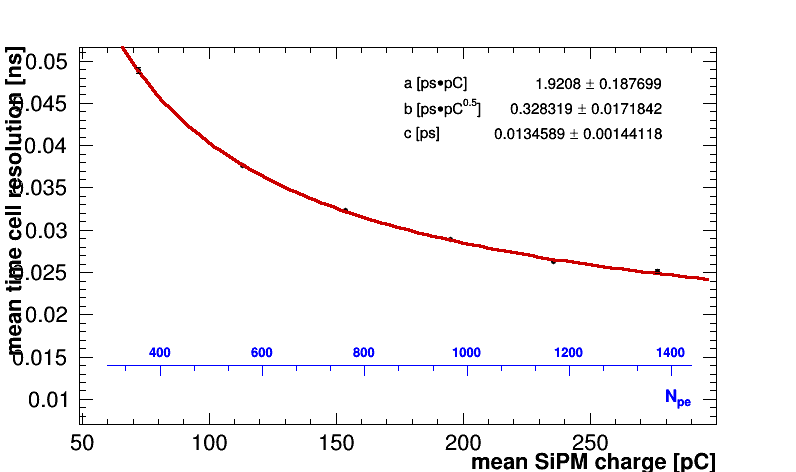

In [275]:
eMin = 50
eSteps = 6
eMax = 300
steps = np.linspace(eMin, eMax, eSteps+1)
stepsNo = steps.shape[0]

fout = TFile(out + "resoCorr.root", "recreate")

gra = TGraphErrors("gra")
gra.GetXaxis().SetTitle("mean SiPM charge [pC]")
gra.GetYaxis().SetTitle("mean time cell resolution [ns]")
gra.SetTitle(run)

for i, thisEne in enumerate(steps):
    if(i+1 == stepsNo): break
    sliceName = F"slice_{i}"
    histo.GetXaxis().SetRangeUser(steps[i], steps[i+1])
    slice = histo.ProjectionY()
    fitf = TF1("fitf", "gaus", -1, 1)
    fitf.SetParameter(1, slice.GetBinCenter(slice.GetMaximumBin()))
    fitf.SetParameter(2, 0.2*slice.GetRMS())
    slice.Fit(fitf, "REMQ")
    charg = histo.ProjectionX()
    FillGraph(gra, charg.GetMean(), fitf.GetParameter(2), charg.GetRMS()/math.sqrt(charg.Integral()), fitf.GetParError(2))
    fout.cd()
    slice.Write()
    charg.Write()
    slice.Delete()

gra.Write()

_, cc = NewCanvas()
gStyle.SetOptFit(11)
gStyle.SetFitFormat("g")

fitf = TF1("fitf", "sqrt([0]*[0]/(x*x) + [1]*[1]/x + [2]*[2])")
fitf.SetParNames("a [ps#bulletpC]", "b [ps#bulletpC^{0.5}]", "c [ps]")

# fitf = TF1("fitf", "sqrt([0]*[0]/(x*x) + [1]*[1])")
# fitf.SetParNames("a [ps#bulletpC]", "b [ps]")

r = gra.Fit(fitf)

gra.SetMarkerStyle(20)
gra.SetMarkerSize(.5)

qFrom, qTo = 50, 300
scalenpe = 2.48*2
npeHeigth = 7e-3

gra.SetMinimum(npeHeigth)
gra.GetXaxis().SetRangeUser(qFrom, qTo)
fnpe = TF1("fnpe", F"x*{scalenpe}")
fnpe.SetRange(fnpe.Eval(qFrom+10), fnpe.Eval(qTo-10))
anpe = TGaxis(qFrom+10, 2*npeHeigth, qTo-10, 2*npeHeigth, "fnpe", 510, "-")
anpe.SetTitle("N_{pe}")
anpe.SetTitleOffset(-1.1)
anpe.SetLabelSize(0.03)
anpe.SetLineColor(kBlue)
anpe.SetLabelColor(kBlue)
anpe.SetTextColor(kBlue)
#anpeSetTitleSize(0.06)

gra.Draw("AP")
anpe.Draw("same")

cc.SaveAs(out + "reso_cor.pdf")
cc.SaveAs(out + "reso_corr.C")

fout.Close()

 FCN=34.5856 FROM MIGRAD    STATUS=CONVERGED      83 CALLS          84 TOTAL
                     EDM=3.60955e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  a [ns#bulletpC]   3.06476e+00   2.55501e-02   4.84808e-05   1.61711e-03
   2  b [ns]       2.20244e-02   1.62410e-04   3.08169e-07  -3.03194e-01


Error in <TGraphErrors::TGraphErrors>: Cannot open file: gra, TGraphErrors is Zombie
Info in <TCanvas::Print>: pdf file out/run530164/reso_corr/reso_corSpline.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: out/run530164/reso_corr/reso_corrSpline.C has been generated


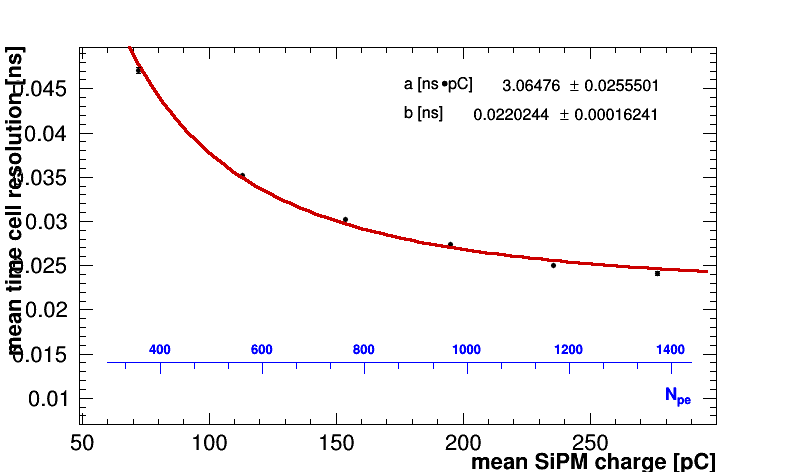

In [276]:
histo = histoS

eMin = 50
eSteps = 6
eMax = 300
steps = np.linspace(eMin, eMax, eSteps+1)
stepsNo = steps.shape[0]

fout = TFile(out + "resoCorr.root", "recreate")

gra = TGraphErrors("gra")
gra.GetXaxis().SetTitle("mean SiPM charge [pC]")
gra.GetYaxis().SetTitle("mean time cell resolution [ns]")
gra.SetTitle(run)

for i, thisEne in enumerate(steps):
    if(i+1 == stepsNo): break
    sliceName = F"slice_{i}"
    histo.GetXaxis().SetRangeUser(steps[i], steps[i+1])
    slice = histo.ProjectionY()
    fitf = TF1("fitf", "gaus", -1, 1)
    fitf.SetParameter(1, slice.GetBinCenter(slice.GetMaximumBin()))
    fitf.SetParameter(2, 0.2*slice.GetRMS())
    slice.Fit(fitf, "REMQ")
    charg = histo.ProjectionX()
    FillGraph(gra, charg.GetMean(), fitf.GetParameter(2), charg.GetRMS()/math.sqrt(charg.Integral()), fitf.GetParError(2))
    fout.cd()
    slice.Write()
    charg.Write()
    slice.Delete()

gra.Write()

_, cc = NewCanvas()
gStyle.SetOptFit(11)
gStyle.SetFitFormat("g")

# fitf = TF1("fitf", "sqrt([0]*[0]/(x*x) + [1]*[1]/x + [2]*[2])")
# fitf.SetParNames("a [ns#bulletpC]", "b [ns#bulletpC^{0.5}]", "c [ns]")

fitf = TF1("fitf", "sqrt([0]*[0]/(x*x) + [1]*[1])")
fitf.SetParNames("a [ns#bulletpC]", "b [ns]")

r = gra.Fit(fitf)

gra.SetMarkerStyle(20)
gra.SetMarkerSize(.5)

qFrom, qTo = 50, 300
scalenpe = 2.48*2
npeHeigth = 7e-3

gra.SetMinimum(npeHeigth)
gra.GetXaxis().SetRangeUser(qFrom, qTo)
fnpe = TF1("fnpe", F"x*{scalenpe}")
fnpe.SetRange(fnpe.Eval(qFrom+10), fnpe.Eval(qTo-10))
anpe = TGaxis(qFrom+10, 2*npeHeigth, qTo-10, 2*npeHeigth, "fnpe", 510, "-")
anpe.SetTitle("N_{pe}")
anpe.SetTitleOffset(-1.1)
anpe.SetLabelSize(0.03)
color = kBlue
anpe.SetLineColor(color)
anpe.SetLabelColor(color)
anpe.SetTextColor(color)
#anpeSetTitleSize(0.06)

gra.Draw("AP")
anpe.Draw("same")

cc.SaveAs(out + "reso_corSpline.pdf")
cc.SaveAs(out + "reso_corrSpline.C")

fout.Close()

 FCN=5.04402 FROM MIGRAD    STATUS=CONVERGED     237 CALLS         238 TOTAL
                     EDM=1.24085e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  a [ns#bulletpC]   2.41887e+00   1.37179e-01   2.51757e-05   7.28255e-03
   2  b [ns#bulletpC^{0.5}]   2.36440e-01   2.16305e-02   2.01483e-06   7.57248e-02
   3  c [ns]       1.72540e-02   1.01367e-03   1.61698e-07   6.63017e-01


Error in <TGraphErrors::TGraphErrors>: Cannot open file: gra, TGraphErrors is Zombie
Info in <TCanvas::Print>: pdf file out/run530164/reso_corr/reso_corSpline_3par.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: out/run530164/reso_corr/reso_corrSpline_3par.C has been generated


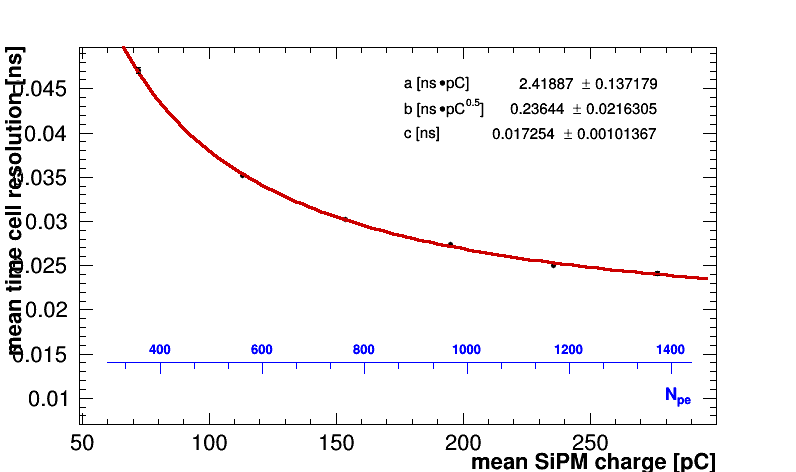

In [277]:
histo = histoS

eMin = 50
eSteps = 6
eMax = 300
steps = np.linspace(eMin, eMax, eSteps+1)
stepsNo = steps.shape[0]

fout = TFile(out + "resoCorr.root", "recreate")

gra = TGraphErrors("gra")
gra.GetXaxis().SetTitle("mean SiPM charge [pC]")
gra.GetYaxis().SetTitle("mean time cell resolution [ns]")
gra.SetTitle(run)

for i, thisEne in enumerate(steps):
    if(i+1 == stepsNo): break
    sliceName = F"slice_{i}"
    histo.GetXaxis().SetRangeUser(steps[i], steps[i+1])
    slice = histo.ProjectionY()
    fitf = TF1("fitf", "gaus", -1, 1)
    fitf.SetParameter(1, slice.GetBinCenter(slice.GetMaximumBin()))
    fitf.SetParameter(2, 0.2*slice.GetRMS())
    slice.Fit(fitf, "REMQ")
    charg = histo.ProjectionX()
    FillGraph(gra, charg.GetMean(), fitf.GetParameter(2), charg.GetRMS()/math.sqrt(charg.Integral()), fitf.GetParError(2))
    fout.cd()
    slice.Write()
    charg.Write()
    slice.Delete()

gra.Write()

_, cc = NewCanvas()
gStyle.SetOptFit(11)
gStyle.SetFitFormat("g")

fitf = TF1("fitf", "sqrt([0]*[0]/(x*x) + [1]*[1]/x + [2]*[2])")
fitf.SetParNames("a [ns#bulletpC]", "b [ns#bulletpC^{0.5}]", "c [ns]")

# fitf = TF1("fitf", "sqrt([0]*[0]/(x*x) + [1]*[1])")
# fitf.SetParNames("a [ns#bulletpC]", "b [ns]")

r = gra.Fit(fitf)

gra.SetMarkerStyle(20)
gra.SetMarkerSize(.5)

qFrom, qTo = 50, 300
scalenpe = 2.48*2
npeHeigth = 7e-3

gra.SetMinimum(npeHeigth)
gra.GetXaxis().SetRangeUser(qFrom, qTo)
fnpe = TF1("fnpe", F"x*{scalenpe}")
fnpe.SetRange(fnpe.Eval(qFrom+10), fnpe.Eval(qTo-10))
anpe = TGaxis(qFrom+10, 2*npeHeigth, qTo-10, 2*npeHeigth, "fnpe", 510, "-")
anpe.SetTitle("N_{pe}")
anpe.SetTitleOffset(-1.1)
anpe.SetLabelSize(0.03)
color = kBlue
anpe.SetLineColor(color)
anpe.SetLabelColor(color)
anpe.SetTextColor(color)
#anpeSetTitleSize(0.06)

gra.Draw("AP")
anpe.Draw("same")

cc.SaveAs(out + "reso_corSpline_3par.pdf")
cc.SaveAs(out + "reso_corrSpline_3par.C")

fout.Close()